In [1]:
import numpy as np 
import pandas as pd 
import json
import re

from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint

import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = '../../archive'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'doi': str
})
meta_df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/1567045245.py:3: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(metadata_path, dtype={


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
meta_df.count()

cord_uid            1015768
sha                  351674
source_x            1015768
title               1015273
doi                  620123
pmcid                366727
pubmed_id            470047
license             1015768
abstract             785160
publish_time        1013952
authors              992939
journal              930544
mag_id                    0
who_covidence_id     470248
arxiv_id              13588
pdf_json_files       351674
pmc_json_files       295705
url                  649539
s2_id                939940
dtype: int64

In [4]:
meta_df.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

## Choose paper to process

- 2021 or newer
- delete with missing abstract
- delete with duplicated abstract

In [5]:
meta_df = meta_df[meta_df.publish_time>='2021']
meta_df.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
meta_df.drop_duplicates(subset=['abstract'],keep='first',inplace=True)

In [6]:
meta_df.count()

cord_uid            394019
sha                 169267
source_x            394019
title               393972
doi                 289955
pmcid               164313
pubmed_id           199711
license             394019
abstract            394019
publish_time        394019
authors             392821
journal             359234
mag_id                   0
who_covidence_id    171060
arxiv_id              7206
pdf_json_files      169267
pmc_json_files      146622
url                 297980
s2_id               368222
dtype: int64

In [7]:
import random

random.seed(42)

data = meta_df.sample(n=50000)

## Stopwords

In [8]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['yourself', 'them', 'we', '’re', 'up', "'re", 'for', 'except', 'her', 'same']

In [9]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
        
lst_stopwords = stopwords

In [10]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
data['abstract_clean'] = data['abstract'].apply(lambda x: x.split())

# Take only English paper
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if w.isalpha()])
# Remove Stopwords
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if w not in lst_stopwords])
# Remove words with single characters
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if len(w)>1])
data.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean
861445,u30a6jiu,4dc50fed48b2ec1be44a395fc1ea4991eba66e06,Elsevier; Medline; PMC; WHO,"Novel antiviral effects of chloroquine, hydrox...",10.1016/j.nutos.2021.12.004,PMC8795779,35106518,els-covid,objectives coronaviruses are globally emerging...,2022-01-28,"Shaik, Fareeda Begum; Swarnalatha, K.; Mohan, ...",Clin Nutr Open Sci,NaN,NaN,NaN,document_parses/pdf_json/4dc50fed48b2ec1be44a3...,NaN,https://www.sciencedirect.com/science/article/...,246297805.0,"[objectives, coronaviruses, globally, emerging..."
346825,b3c4rb21,NaN,WHO,The performance of corporate bond issuers in t...,NaN,NaN,NaN,unk,purposethe fundamental theory of modigliani an...,2021,"Berninger, Marc Fiesenig Bruno Schiereck Dirk",The Journal of Risk Finance,NaN,#covidwho-1262292,NaN,NaN,NaN,NaN,237872621.0,"[purposethe, fundamental, theory, modigliani, ..."
880730,3vkukx1d,60bf46be1533293497a72cfe27f19136dc5c5729,Medline; PMC,Alternate delivery platforms and implementatio...,10.1186/s43058-022-00259-5,PMC8848683,35168661,cc-by,background: youth functioning and organization...,2022-02-16,"Bond, Laura; Farrar, Jordan; Borg, Ryan C.; Ke...",Implement Sci Commun,NaN,NaN,NaN,document_parses/pdf_json/60bf46be1533293497a72...,document_parses/pmc_json/PMC8848683.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/35168661/;...,246830072.0,"[youth, functioning, organizational, success, ..."
667792,mlht1frb,c8ceef1774da1207a425dcb3951cd2989ac0a59d,BioRxiv; WHO,Context-aware deconvolution of cell-cell commu...,10.1101/2021.09.20.461129,NaN,NaN,biorxiv,"cell interactions determine phenotypes, and in...",2021-09-23,"Armingol, Erick; Baghdassarian, Hratch M.; Mar...",bioRxiv,NaN,NaN,NaN,document_parses/pdf_json/c8ceef1774da1207a425d...,NaN,https://doi.org/10.1101/2021.09.20.461129,237637949.0,"[cell, interactions, determine, intercellular,..."
764640,um6cws9c,c6e83cc3e385bfeea60b815ebb6eae343f347a91,Medline; PMC,Automated Cobb Angle Measurement for Adolescen...,10.3390/diagnostics12020396,PMC8871012,35204487,cc-by,the cobb angle measurement of the scoliotic sp...,2022-02-03,"Caesarendra, Wahyu; Rahmaniar, Wahyu; Mathew, ...",Diagnostics (Basel),NaN,NaN,NaN,document_parses/pdf_json/c6e83cc3e385bfeea60b8...,document_parses/pmc_json/PMC8871012.xml.json,https://doi.org/10.3390/diagnostics12020396; h...,246592062.0,"[cobb, angle, measurement, scoliotic, spine, p..."


In [11]:
data.reset_index(drop=True,inplace=True)

In [12]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_clean'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 97221 unique words in inverted index


In [13]:
data['abstract_clean']

0        [objectives, coronaviruses, globally, emerging...
1        [purposethe, fundamental, theory, modigliani, ...
2        [youth, functioning, organizational, success, ...
3        [cell, interactions, determine, intercellular,...
4        [cobb, angle, measurement, scoliotic, spine, p...
                               ...                        
49995    [global, outbreak, coronavirus, disease, wides...
49996    [practice, race, ethnicity, medicine, explain,...
49997    [endothelium, plays, fundamental, role, cardio...
49998    [risk, perception, quantify, risks, industry, ...
49999    [chest, infections, medical, case, reports, kn...
Name: abstract_clean, Length: 50000, dtype: object

In [14]:
keywords_risk = ['risk','risky','risks','risked','risking', 'severity', 'severe']
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 15056 articles related to risk


In [15]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean
32768,tuj2uvlm,6094f2d8e208c66c9ca01b5155a9ae30a2e3531b,Medline; PMC; WHO,Diagnostic Value of High-Resolution Computed T...,10.7759/cureus.15849,PMC8299315,34322339,cc-by,background and objective the ambiguous nature ...,2021-06-23,"Khan, Muhammad Sheharyar; Janjua, Muhammad Bil...",Cureus,NaN,NaN,NaN,document_parses/pdf_json/6094f2d8e208c66c9ca01...,document_parses/pmc_json/PMC8299315.xml.json,https://doi.org/10.7759/cureus.15849; https://...,236469969.0,"[background, objective, ambiguous, nature, hig..."
32770,tcsp4b9x,NaN,WHO,Multisystemic Long-Term Sequelae of Covid-19: ...,NaN,NaN,NaN,unk,"on january 7, 2020, it was announced that the ...",2021,"Sahin, A. R.; Kocyigit, B. F.; Aksu, E.; Akkok...",Eurasian Journal of Medicine and Oncology,NaN,#1158461,NaN,NaN,NaN,NaN,232097030.0,"[january, announced, chinese, government, isol..."
6,84s1otnm,NaN,WHO,Acute pulmonary embolism in hospitalized patie...,NaN,NaN,NaN,unk,purpose: to analyze pulmonary embolism (pe) on...,2021,"Ippolito, Davide; Giandola, Teresa; Maino, Ces...",NaN,NaN,#1014200,NaN,NaN,NaN,NaN,231194001.0,"[analyze, pulmonary, embolism, chest, computed..."
32775,c31r023e,NaN,PMC; WHO,352. COVID-19 Not a Risk Factor of Alopecia Ar...,10.1093/ofid/ofab466.553,PMC8644810,NaN,cc-by,background: there have been approximately 158 ...,2021-12-04,"Kim, Jeehyun; Hong, Kwan; Yum, Sujin; Gomez, R...",Open Forum Infect Dis,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1093/ofid/ofab466.553,244917189.0,"[approximately, million, coronavirus, disease,..."
8,ve88ztzg,NaN,WHO,Clinical Utility of Biosensing Platforms for C...,NaN,NaN,NaN,unk,despite collaborative efforts from all countri...,2021,"Phan, Le Minh Tu Tieu My-Van Pham Thi-Thu Cho ...",Biosensors,NaN,#1243953,NaN,NaN,NaN,NaN,235300439.0,"[despite, collaborative, efforts, coronavirus,..."


In [16]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']): #['NOUN','ADJ','VERB','ADV'] ['DISEASE', 'CHEMICAL']
    texts_out = []
    nlp = spacy.load('en_ner_bc5cdr_md', disable=['parser', 'ner']) #en_core_web_sm  en_ner_bc5cdr_md
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out   


/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3572533099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_clean']))
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3572533099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])


Text(0.5, 1.0, 'Word Cloud: Articles Related to Risk Factor')

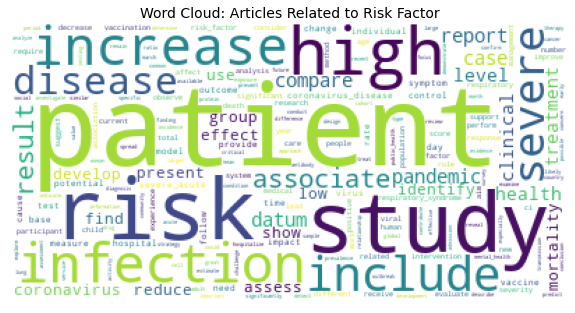

In [17]:
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_clean']))

bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])

risk_abstract_tokens = []
for tokens in list(risk_article['Phrase_Lemma_Tokens']):
    risk_abstract_tokens += tokens
risk_wordcnt_dict = collections.Counter(risk_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(risk_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to Risk Factor' ,fontsize=14)

In [18]:
risk_article.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean,Lemma_Tokens,Phrase_Lemma_Tokens
32768,tuj2uvlm,6094f2d8e208c66c9ca01b5155a9ae30a2e3531b,Medline; PMC; WHO,Diagnostic Value of High-Resolution Computed T...,10.7759/cureus.15849,PMC8299315,34322339,cc-by,background and objective the ambiguous nature ...,2021-06-23,...,NaN,NaN,NaN,document_parses/pdf_json/6094f2d8e208c66c9ca01...,document_parses/pmc_json/PMC8299315.xml.json,https://doi.org/10.7759/cureus.15849; https://...,236469969.0,"[background, objective, ambiguous, nature, hig...","[background, objective, ambiguous, nature, hig...","[background, objective, ambiguous, nature, hig..."
32770,tcsp4b9x,NaN,WHO,Multisystemic Long-Term Sequelae of Covid-19: ...,NaN,NaN,NaN,unk,"on january 7, 2020, it was announced that the ...",2021,...,NaN,#1158461,NaN,NaN,NaN,NaN,232097030.0,"[january, announced, chinese, government, isol...","[january, announce, chinese, government, isola...","[january, announce, chinese_government, isolat..."
6,84s1otnm,NaN,WHO,Acute pulmonary embolism in hospitalized patie...,NaN,NaN,NaN,unk,purpose: to analyze pulmonary embolism (pe) on...,2021,...,NaN,#1014200,NaN,NaN,NaN,NaN,231194001.0,"[analyze, pulmonary, embolism, chest, computed...","[analyze, pulmonary, embolism, chest, compute,...","[analyze, pulmonary_embolism, chest_compute, t..."
32775,c31r023e,NaN,PMC; WHO,352. COVID-19 Not a Risk Factor of Alopecia Ar...,10.1093/ofid/ofab466.553,PMC8644810,NaN,cc-by,background: there have been approximately 158 ...,2021-12-04,...,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1093/ofid/ofab466.553,244917189.0,"[approximately, million, coronavirus, disease,...","[approximately, coronavirus, disease, pandemic...","[approximately, coronavirus_disease, pandemic,..."
8,ve88ztzg,NaN,WHO,Clinical Utility of Biosensing Platforms for C...,NaN,NaN,NaN,unk,despite collaborative efforts from all countri...,2021,...,NaN,#1243953,NaN,NaN,NaN,NaN,235300439.0,"[despite, collaborative, efforts, coronavirus,...","[collaborative, effort, coronavirus, disease, ...","[collaborative_effort, coronavirus_disease, pa..."


100%|███████████████████████████████████████████████████████████████████████████| 8/8 [06:29<00:00, 48.65s/it]

Topic number selection took 389.294469833374 seconds


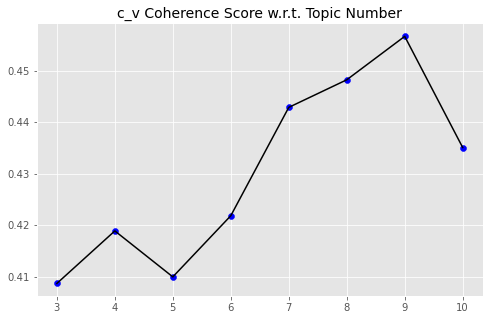

In [19]:
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))

corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)

    cm = CoherenceModel(model=lda_model, 
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

In [20]:
len(list(risk_article['Phrase_Lemma_Tokens']))

15056

In [64]:
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=6, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -8.157568631139888


/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/3526752618.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabe

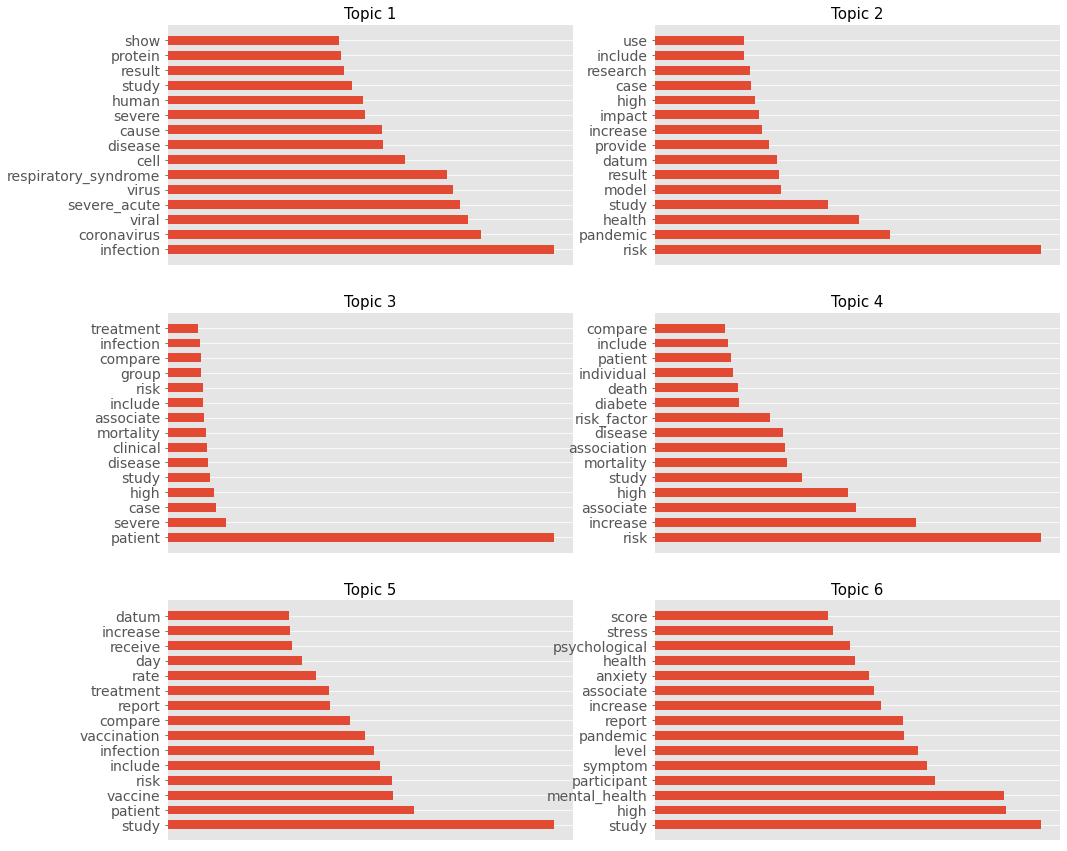

In [65]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(3,2,i+1)
    ax.barh(y=words,width=probs,height=0.6)
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

In [66]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_risk_article, id2token_risk_article)

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/

CPU times: user 5.28 s, sys: 102 ms, total: 5.38 s
Wall time: 5.92 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.054794  0.164706       1        1  28.375094
2      0.011166 -0.132613       2        1  23.580714
0     -0.231286 -0.004815       3        1  17.530119
4      0.037464 -0.013184       4        1  15.108390
5      0.169681  0.106378       5        1   8.865740
3      0.067769 -0.120472       6        1   6.539944, topic_info=          Term          Freq         Total Category  logprob  loglift
63     patient  26718.000000  26718.000000  Default  30.0000  30.0000
127       risk  13135.000000  13135.000000  Default  29.0000  29.0000
403   increase   7834.000000   7834.000000  Default  28.0000  28.0000
383  associate   6093.000000   6093.000000  Default  27.0000  27.0000
38        high   8871.000000   8871.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
578        low    322.979505   3880.445605   Topic6  -5.6441   0.2411
63     patient    468.895887  26718.821203   Topic6  -5.2713  -1.3155
111  infection    343.930196   8084.504870   Topic6  -5.5813  -0.4300
814     factor    293.090220   2418.996412   Topic6  -5.7412   0.6166
180       show    292.349765   4129.350482   Topic6  -5.7437   0.0793

[515 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
422       1  0.822517      access
422       2  0.023660      access
422       4  0.141957      access
422       5  0.011134      access
422       6  0.001392      access
...     ...       ...         ...
1034      4  0.010428        work
1034      5  0.225572        work
1034      6  0.000549        work
1496      1  0.997417   workplace
6425      5  0.994833  write_user

[1142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 6, 4])

In [67]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/1691480270.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)


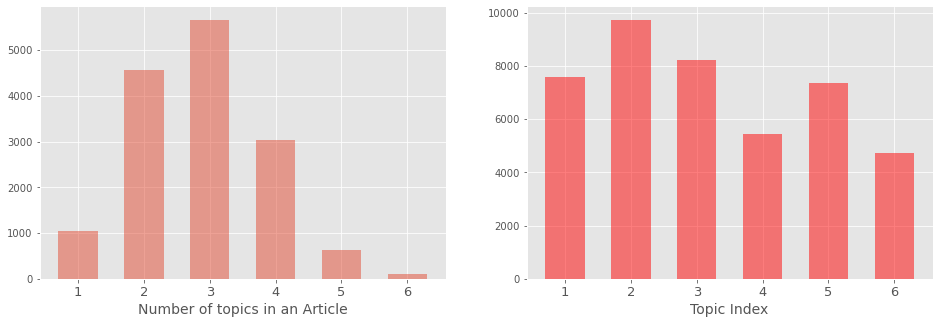

In [68]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

In [69]:
document_topic_matrix.shape

(15056, 3)

In [72]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix)

,0,1,2,3,4,5
0,0.088514,0.000000,0.905625,0.000000,0.000000,0.000000
1,0.191697,0.554007,0.244386,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.990758,0.000000,0.000000,0.000000
3,0.000000,0.084265,0.512321,0.000000,0.363422,0.037146
4,0.576382,0.416221,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
15051,0.285553,0.000000,0.534680,0.174115,0.000000,0.000000
15052,0.000000,0.264519,0.000000,0.000000,0.728607,0.000000
15053,0.000000,0.740988,0.000000,0.068336,0.186314,0.000000
15054,0.048685,0.000000,0.370244,0.438089,0.138786,0.000000


In [73]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Treatment Methods', 1: 'Mental Health and Behavior', 2: 'Severity of Disease', 
                  3: 'Transmission of Virus', 4: 'Public and Social Service', 5:'Death'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])
df_embedding['article_title'] = list(risk_article['title'])
# pdf_json_files
df_embedding['pdf_json_files'] = list(risk_article['pdf_json_files'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [78]:
df_embedding

,X_TSNE,Y_TSNE,dominant_topic_idx,color,label,article_title,pdf_json_files
0,-80.513496,-30.003365,2,yellow,Severity of Disease,Diagnostic Value of High-Resolution Computed T...,document_parses/pdf_json/6094f2d8e208c66c9ca01...
1,24.979761,33.612495,1,green,Mental Health and Behavior,Multisystemic Long-Term Sequelae of Covid-19: ...,NaN
2,-33.994583,-82.226761,2,yellow,Severity of Disease,Acute pulmonary embolism in hospitalized patie...,NaN
3,-13.820454,-19.797230,2,yellow,Severity of Disease,352. COVID-19 Not a Risk Factor of Alopecia Ar...,NaN
4,26.923098,55.088451,0,blue,Treatment Methods,Clinical Utility of Biosensing Platforms for C...,NaN
...,...,...,...,...,...,...,...
15051,-68.077400,10.715731,2,yellow,Severity of Disease,A higher BMI is not associated with a differen...,document_parses/pdf_json/ce2d83790c9600eb0f657...
15052,16.853081,1.613749,4,skyblue,Public and Social Service,Bayesian hypothesis testing and hierarchical m...,document_parses/pdf_json/7db56c0718c739c248df5...
15053,51.727882,7.936222,1,green,Mental Health and Behavior,"COVID-19, green space exposure, and mask mandates",document_parses/pdf_json/76e0dee569601274ad6cf...
15054,-32.507053,9.082541,3,red,Transmission of Virus,Use of proton pump inhibitors are associated w...,document_parses/pdf_json/f25921bba90d644e0501e...


In [87]:
df_final = df_embedding[df_embedding['dominant_topic_idx'] == 2]

In [88]:
# all_json = ! ls $root_path/document_parses/pdf_json
# all_json = meta_df['pdf_json_files'].tolist()
all_json = df_final['pdf_json_files'].dropna()
len(all_json)

1649

In [89]:
all_json = all_json.str.split('; ').str[0]

In [90]:
len(all_json)

1649

In [92]:
all_json[18]

'document_parses/pdf_json/5558483ac016f3924a56a507ebf1a7709b0f1a22.json'

In [93]:
all_json = [root_path + "/" + s for s in all_json]
# all_json = [root_path + "" + s for s in all_json]

all_json[:5]

['../../archive/document_parses/pdf_json/6094f2d8e208c66c9ca01b5155a9ae30a2e3531b.json',
 '../../archive/document_parses/pdf_json/1d066aef96639bbad3da4c4b80e830331e5a23ad.json',
 '../../archive/document_parses/pdf_json/5558483ac016f3924a56a507ebf1a7709b0f1a22.json',
 '../../archive/document_parses/pdf_json/fa932ba2abbae3d7558f67ef7ace0f51995d5d82.json',
 '../../archive/document_parses/pdf_json/08dd75b167c1586bd9dcb88f2ed7dcaa290a3571.json']

In [94]:
with open(all_json[0]) as file:
    x = json.load(file)
x['paper_id']

# meta_df['sha']

'6094f2d8e208c66c9ca01b5155a9ae30a2e3531b'

In [95]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            # self.publish_time = content['publish_time']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

6094f2d8e208c66c9ca01b5155a9ae30a2e3531b: The ambiguous nature and high infectivity of the coronavirus disease 2019 (COVID-19) have caused soaring morbidity and mortality worldwide. Real-time polymerase chain reaction (RT-PCR) is preferred fo... The coronavirus disease 2019 (COVID-19) pandemic has severely paralyzed healthcare systems worldwide [1] . The highly transmissible virus belongs to a family of respiratory viruses and was named sever...


In [96]:
from tqdm import tqdm
all_json_clean = list()
for idx, entry in tqdm(enumerate(all_json), total=len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.body_text) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

100%|████████████████████████████████████████████████████████████████████| 1649/1649 [00:02<00:00, 660.29it/s]


1643

In [ ]:
import random

random.seed(42)

all_json = random.sample(all_json, 1000)

In [97]:
all_json[:5]

['../../archive/document_parses/pdf_json/6094f2d8e208c66c9ca01b5155a9ae30a2e3531b.json',
 '../../archive/document_parses/pdf_json/1d066aef96639bbad3da4c4b80e830331e5a23ad.json',
 '../../archive/document_parses/pdf_json/5558483ac016f3924a56a507ebf1a7709b0f1a22.json',
 '../../archive/document_parses/pdf_json/fa932ba2abbae3d7558f67ef7ace0f51995d5d82.json',
 '../../archive/document_parses/pdf_json/08dd75b167c1586bd9dcb88f2ed7dcaa290a3571.json']

In [98]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [99]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': [], 'publish_time': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    # dict_['publish_time'].append(content.publish_time)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

100%|█████████████████████████████████████████████████████████████████████| 1643/1643 [00:43<00:00, 37.42it/s]


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,6094f2d8e208c66c9ca01b5155a9ae30a2e3531b,10.7759/cureus.15849,The ambiguous nature and high infectivity of t...,The coronavirus disease 2019 (COVID-19) pandem...,"Khan, Muhammad Sheharyar. Janjua, Muhammad<b...",Diagnostic Value of High-Resolution Computed<...,Cureus,The ambiguous nature and high infectivity of<...
1,1d066aef96639bbad3da4c4b80e830331e5a23ad,10.12659/ajcr.935263,,"Background C-reactive protein (CRP), the proto...","Schumann, Christian. Heigl, Franz. Rohrbach...",A Report on the First 7 Sequential Patients<b...,Am J Case Rep,Not provided.
2,5558483ac016f3924a56a507ebf1a7709b0f1a22,10.1016/j.anpede.2020.10.007,,"Since December 2019, infection by SARS-CoV-2 h...","Nogueira López, Javier. Grasa Lozano, Carlos...",Telemedicine follow-ups for COVID-19:<br>Expe...,An Pediatr (Engl Ed),Not provided.
3,fa932ba2abbae3d7558f67ef7ace0f51995d5d82,10.1016/j.thromres.2021.10.001,-The risk of VTE in patients with mild and mod...,The coronavirus disease 2019 (COVID-19) viral ...,"Douillet, Delphine. Riou, Jérémie. Penaloza...",Risk of symptomatic venous thromboembolism in...,Thromb Res,-The risk of VTE in patients with mild and<br...
4,08dd75b167c1586bd9dcb88f2ed7dcaa290a3571,10.34172/jrhs.2021.41,,oronavirus disease 2019 (COVID-19) is a corona...,"Hosseinzadeh, Ali. Rezapour, Maysam. <br>Roh...",Epidemiological patterns of syndromic<br>symp...,J Res Health Sci,Not provided.


In [100]:
# df_covid['body_text'][2]

# Preprocessing
## Handling multiple languages

In [101]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|████████████████████████████████████████████████████████████████████| 1557/1557 [00:07<00:00, 200.06it/s]


In [113]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 1557

{'de': 10, 'en': 1521, 'es': 19, 'fr': 5, 'pt': 2}


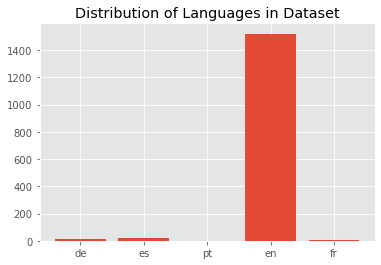

In [114]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [115]:
df = df_covid[df_covid['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1521 entries, 0 to 1556
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          1521 non-null   object
 1   doi               1518 non-null   object
 2   abstract          1521 non-null   object
 3   body_text         1521 non-null   object
 4   authors           1518 non-null   object
 5   title             1521 non-null   object
 6   journal           1455 non-null   object
 7   abstract_summary  1521 non-null   object
 8   language          1521 non-null   object
dtypes: object(9)
memory usage: 118.8+ KB


In [116]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    pat = r'\d+'
    text = re.sub(pat, '', text)
    # r'[^a-zA-z0-9.,!?/:;\"\'\s]
    # r'[^\w\s]
    
    # text = text.replace(r'\d+','')
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    # removed_numbers = dataframe.str.replace(r'\d+','')
        
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [117]:
def apply_preprocess(df):
    df["body_text_clean"] = df["body_text"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [118]:
def apply_preprocess_abstract(df):
    df["abstract_clean"] = df["abstract"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [119]:
df = apply_preprocess(df)

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/124836987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["body_text_clean"] = df["body_text"].apply(lambda x:


In [120]:
df = apply_preprocess_abstract(df)
df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_19742/1022252229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["abstract_clean"] = df["abstract"].apply(lambda x:


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,body_text_clean,abstract_clean
0,6094f2d8e208c66c9ca01b5155a9ae30a2e3531b,10.7759/cureus.15849,The ambiguous nature and high infectivity of t...,The coronavirus disease 2019 (COVID-19) pandem...,"Khan, Muhammad Sheharyar. Janjua, Muhammad<b...",Diagnostic Value of High-Resolution Computed<...,Cureus,The ambiguous nature and high infectivity of<...,en,coronavirus disease covid pandemic severely pa...,ambiguous nature high infectivity coronavirus ...
1,1d066aef96639bbad3da4c4b80e830331e5a23ad,10.12659/ajcr.935263,,"Background C-reactive protein (CRP), the proto...","Schumann, Christian. Heigl, Franz. Rohrbach...",A Report on the First 7 Sequential Patients<b...,Am J Case Rep,Not provided.,en,background creactive protein crp prototype hum...,
2,5558483ac016f3924a56a507ebf1a7709b0f1a22,10.1016/j.anpede.2020.10.007,,"Since December 2019, infection by SARS-CoV-2 h...","Nogueira López, Javier. Grasa Lozano, Carlos...",Telemedicine follow-ups for COVID-19:<br>Expe...,An Pediatr (Engl Ed),Not provided.,en,december infection sarscov spread rapidly worl...,
3,fa932ba2abbae3d7558f67ef7ace0f51995d5d82,10.1016/j.thromres.2021.10.001,-The risk of VTE in patients with mild and mod...,The coronavirus disease 2019 (COVID-19) viral ...,"Douillet, Delphine. Riou, Jérémie. Penaloza...",Risk of symptomatic venous thromboembolism in...,Thromb Res,-The risk of VTE in patients with mild and<br...,en,coronavirus disease covid viral pneumonia lead...,risk vte patient mild moderate covid remains d...
4,08dd75b167c1586bd9dcb88f2ed7dcaa290a3571,10.34172/jrhs.2021.41,,oronavirus disease 2019 (COVID-19) is a corona...,"Hosseinzadeh, Ali. Rezapour, Maysam. <br>Roh...",Epidemiological patterns of syndromic<br>symp...,J Res Health Sci,Not provided.,en,oronavirus disease covid coronavirus outbreak ...,


In [121]:
# dropping null value columns to avoid errors
df_test = df.dropna()
 
# substring to be searched
sub = 'severity'

sub2 = 'risk factor'
 
# creating and passing series to new column
# df_test["abstract_sev_index"]= df_test["abstract_clean"].str.find(sub)
# df_test["abstract_ris_index"]= df_test["abstract_clean"].str.find(sub2)

df_test = df_test[df_test['abstract_clean'].str.contains('severity|risk factor')]
 

In [122]:
# df_test[df_test['abstract_ris_index'] != -1]['abstract_clean']

In [123]:
df_test = df_test[df_test['abstract_sev_index'] != -1 or df_test['abstract_ris_index'] != -1]

KeyError: 'abstract_sev_index'

In [ ]:
df['body_text_clean'][0]

In [ ]:
df_test.head()

In [ ]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz

In [ ]:
def extract_paper_annotations():
    """
    This function looks at all the papers in the CORD-19 dataset and extract entities
    """
    # Define the list of papers we will process
    #papers = [Path("/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/59eab95c43fdea01481fdbf9bae45dfe28ffc693.json")]
    papers = [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('comm_use_subset/comm_use_subset/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('noncomm_use_subset/noncomm_use_subset/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('custom_license/custom_license/pdf_json/*.json')]
    print (len(papers)) 

    # Load the NLP models
    nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...
    nlp_model_bc5cdr = spacy.load("en_ner_bc5cdr_md") # For diseases

    # The output will be one hashmap associating each paper to its annotations
    output = {}

    # Process all the papers
    for paper in tqdm(papers):
        try:
            # Load the document
            document = json.loads(paper.read_text())

            # Get the ID
            paper_id = document['paper_id']
            
            # Initialise its entry
            output[paper_id] = {}
            output[paper_id]['topics'] = {} # The different topic annotations grouped per type
            
            # Group the text by sections (took more than 9h to process!)
            #section_texts = {}
            #section_texts['abstract'] = []
            #for b in document['abstract']:
            #    section_texts['abstract'].append(b['text'])
            #for b in document['body_text']:
            #    section_texts.setdefault(b['section'], [])
            #    section_texts[b['section']].append(b['text'])

            # Retrieve all the text
            texts = []
            for b in document['abstract']:
                texts.append(b['text'])
            if 'body_text' in document:
                for b in document['body_text']:
                    texts.append(b['text'])
            
            # Process the different sections to extract entities
            #for section,texts in section_texts.items():
            text = '.'.join(texts)
            for nlp_model in [nlp_model_bionlp13cg, nlp_model_bc5cdr]:
                tokens = nlp_model(text)
                for entity in tokens.ents:
                    topic_type = entity.label_
                    topic_value = str(entity.text)
                    output[paper_id]['topics'].setdefault(topic_type, set())
                    output[paper_id]['topics'][topic_type].add(topic_value)
            
        except Exception as e:
            print ('Error with {}'.format(paper))
            print (e)

    # Turn the sets into lists to save them as JSON
    for paper_id in output.keys():
        for topic_type in output[paper_id]['topics'].keys():
            output[paper_id]['topics'][topic_type] = list(output[paper_id]['topics'][topic_type])

    return output

In [124]:
import scispacy
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")
nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...


In [125]:
doc = nlp(df['body_text'][109])

In [126]:
print("TEXT", "START", "END", "ENTITY TYPE")
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

TEXT START END ENTITY TYPE
acute respiratory syndrome coronavirus 2 (SARS-CoV-2) 85 138 DISEASE
Kawasaki 348 356 DISEASE
haemophagocytic lymphohistiocytosis 399 434 DISEASE
HLH 436 439 DISEASE
acute infection 530 545 DISEASE
multi end-organ failure 625 648 DISEASE
heart failure 801 814 DISEASE
fever 913 918 DISEASE
heart failure 923 936 DISEASE
myocarditis 1012 1023 DISEASE
hepatomegaly 1259 1271 DISEASE
leucocytosis 1326 1338 DISEASE
lymphopenia white blood count 13.4 × 10 3 /μL 1343 1388 DISEASE
anaemia 1408 1415 DISEASE
thrombocytopenia 1438 1454 DISEASE
liver and cardiac injury 1584 1608 DISEASE
coagulopathy 1610 1622 DISEASE
pulmonary congestion 1800 1820 DISEASE
biventricular dysfunction 2013 2038 DISEASE
dilated cardiomyopathy 2285 2307 DISEASE
oedema 2313 2319 DISEASE
fibrosis 2339 2347 DISEASE
thrombus 2371 2379 DISEASE
viral aetiologies 2468 2485 DISEASE
bilirubin 2599 2608 CHEMICAL
haemorrhage 2727 2738 DISEASE
necrosis 2743 2751 DISEASE
cardiomyopathy 2781 2795 DISEASE
bi-c